## Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are used to model sequences of arbitrary length (e.g., sequence of words in a sentence, sequence of sentences in a document, sequence of frames in a video). RNNs typically use their internal state (memory) to process sequence of inputs. At each time-step, RNNs output a prediction and hidden state, feeding its previous hidden state into each next step. RNNs are applied in a wide range of NLP applications:
- language modeling, where RNN can condition on **all** previous words in the corpus unlike n-gram language model
- text classification, where the states act as features (we will see sentiment analysis in this tutorial)
- machine translation, where a RNN is used to process a sentence in source language and another RNN is used to decode the sentence in target language (we will see this in the "Machine Translation" course)
- sequence labeling, where the states in RNN are used to predict a category for each item in the sequence (we might see named entity recognition in the next tutorial)

![](images/rnn.png)

Picture Courtesy: https://github.com/UBC-NLP/dlnlp2019/blob/master/slides/RNN.pdf

## RNN for Classification Task 

We now model the text classification task of IMDB movie reviews with a vallina RNN. We'll use the RNN to sequentially process the input sequence of tokens.

### Load Python libraries

In [1]:
# our code was tested with torch==1.11.0 and torchtext==0.12.0
!pip install torch==1.11.0
!pip install torchtext==0.12.0
!pip install torchdata==0.3.0

In [2]:
import torch, torchtext
from torch import nn, Tensor
from torchtext.datasets import IMDB
from torchtext.data import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import dataset, random_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Prepare data

We use load IMDB dataset from `torchtext.datasets`. Please find more details [here](https://pytorch.org/text/stable/datasets.html#imdb).

In [3]:
IMDB_train = IMDB(split="train")
IMDB_train = to_map_style_dataset(IMDB_train)
IMDB_train, IMDB_dev = random_split(IMDB_train, [15000,10000])

Show the first sample in the dataset

In [4]:
IMDB_train[0]

('neg',
 "Hey HULU.com is playing the Elvira late night horror show on their site and this movie is their under the Name Monsteroid, good fun to watch Elvira comment on this Crappy movie ....Have Fun with bad movies. Anyways this movie really has very little value other than to see how bad the 70's were for horror flicks Bad Effects, Bad Dialog, just bad movie making. Avoid this unless you want to laugh at it. While you are at HULU check out the other movies that are their right now there is 10 episodes and some are pretty decent movies with good plots and production and you can watch a lot of them in 480p as long as you have a decent speed connection.")

### Create tokenizer and vocabulary

We use our train set to construct the vocabulary.

In [5]:
tokenizer = get_tokenizer('basic_english')
## We set the vocabulary size to 10K and includw two special tokens for unknow (<unk>) and padding (<pad>) tokens. 
vocab = build_vocab_from_iterator(map(lambda x: tokenizer(x[1]), IMDB_train), max_tokens=10000, specials=['<unk>','<pad>'])
vocab.set_default_index(vocab['<unk>'])

label2index = {'pos': 1, 'neg': 0}

Our vocabulary size is 10,000.

In [6]:
print(len(vocab))

10000


We want to break the full sentence into individual word tokens, and get them in a format our model can handle, here is a basic way to do it:

In [7]:
from typing import List, Optional, Any, Union

class default_tokenizer(nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer

    def forward(self, input: Any) -> Any:
        if torch.jit.isinstance(input, List[str]):
            tokens: List[List[str]] = []
            for text in input:
                tokens.append(self.tokenizer(text))
            return tokens
        elif torch.jit.isinstance(input, str):
            return self.tokenizer(input)
        else:
            raise TypeError("Input type not supported")      

For our text processing, we will use torchtext's Transforms to apply the tokenization and mapping to ID in sequence.

In [8]:
import torchtext.transforms as T

# prepare a container to host a sequence of text transforms. We use our vocabulary and set the maximal sequence
# length to 128. The T.Sequential() will convert string words to ids.
processor = T.Sequential(
    default_tokenizer(tokenizer),
    T.VocabTransform(vocab),
    T.Truncate(128)
    )

# Transform labels from string names to ids.
label_processor = T.Sequential(
    T.LabelToIndex(['pos','neg'] ),
)

Now, we create a dataloader to generate batches. 

In [9]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_processor(_label))
        processed_text = torch.tensor(processor(_text))
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=vocab.__getitem__("<pad>"))


train_dataloader = DataLoader(list(IMDB_train), batch_size=16, shuffle=True, 
                              collate_fn=collate_batch)
dev_dataloader = DataLoader(list(IMDB_dev), batch_size=16, shuffle=False, 
                              collate_fn=collate_batch)

As we memtioned in previous tutorial, we can find that first element is a tensor of labels with a size of `[batch_size]` and the second element is a tensor of input sequences with a size of `[length, batch_size]`.

In [10]:
for item in train_dataloader:
    print(item)
    print(item[0].shape)
    print(item[1].shape)
    break

(tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]), tensor([[3334,  320, 3594,  ...,   46,  607,   14],
        [ 132,   23,   78,  ...,   17, 2141,   21],
        [  34,   15,  824,  ...,    6,   21,    0],
        ...,
        [4465,   20,  150,  ...,    0,    0,   88],
        [ 420,   11,  824,  ...,  405,  144,  278],
        [   0,    4,    3,  ..., 8146,   25,   89]]))
torch.Size([16])
torch.Size([128, 16])


### Modules in RNN for text classification:
1. Embedding layer
2. RNN layer
3. Classification layer

1. Embedding layer: The ``Embedding`` layer will encode each word in the vocabulary by a vector. Now, we will need to tell it what size we want for that vector. Popular values for a vector size are usally between 100-300 for many tasks. Let's set it to 300 dimensions. (You are encouraged to play with this value as practice). All words in the vocabulary will have the same embedding size. Let's put that hyper-parameter in a variable ``WORD_VEC_SIZE``:

In [11]:
WORD_VEC_SIZE= 300

We are now ready to call the ``Embedding`` class to construct an embeddings tensor:

In [12]:
# Constructing an embedding Layer:
embedding = nn.Embedding(len(vocab), WORD_VEC_SIZE)

# apply the embedding layer on the input of the fist batch 
input = item[1]
embedded=embedding(input)
print(embedded.shape) 

torch.Size([128, 16, 300])


After the word embedding layer, the input batch is a tenor of `[sequence length, batch size, embedding size]`.


2. RNN layer: PyTorch has ``torch.nn.RNN`` module that implements the vanilla (Elman) RNN with *tanh* or *ReLU* non-linearity. The documentation for this module is [here](https://pytorch.org/docs/stable/nn.html#torch.nn.RNN). Let us contine using the firt sample batch to understand this module.

We define a single RNN layer with a hidden size of 50. The input_size is equal to the embedding size that is 300 in our example. 

In [13]:
"""
define the RNN module
"""
# first input - number of dimesnions for word vectors for a vector x (300, size of the word embedding)
# second input - number of nodes in hidden state h_t (50, size of the hidden layer)
# third input - number of recurrent layers (we set it to 1)
rnn_layer = nn.RNN(input_size=300, hidden_size=50, num_layers=1) # input_size, hidden_size, num_layers

We will now pass the ``embedded`` tensor (representations of words in our batch) to RNN. 

In [14]:
"""
forward propagation over the RNN model
"""
rnn_output, hn = rnn_layer(embedded)

But what is ``rnn_output``? Well, let's inspect its shape first:

In [15]:
# output = seq_len, batch, hidden_size (output features from last layer of RNN)
print("rnn_output size: ", rnn_output.size())

rnn_output size:  torch.Size([128, 16, 50])


Here's what we need to know about ``output``:
- The first dimension in the ``output`` tensor is the ``sequence length`` (=128). 
- The second dimension is ``batch_size`` (the number of examples/sentences in our batch = 16).
- The third dimension is the ``size of nodes/units`` in our hidden layer (=50). 

Here's what we need to know about ``hn``:
- ``hn`` is a tensor of shape `[num_layers, batch size, hidden size]` containing the hidden state for the last ``time step`` 
(``t = max_seq_length``).

In [16]:
# h_n = num_layers, batch, hidden_size (hidden state for t=seq_len or hidden state at last timestep)
print("last hidden state size: ", hn.size())

last hidden state size:  torch.Size([1, 16, 50])


You can take the output representation for a text sequence after processing the last token (t=seq_len or last timestep) and call the resulting representation as the tweet representation that **"summarizes" the information present** in the text. This text representation can further be used for the text classification.

Let us compute the final tweet representation:

In [17]:
text_output_embeddings = rnn_output[-1,:,:] # -1 fetches the embeddings from the last timestep
print("text output embeddings size: ", text_output_embeddings.size())
# first dimension - number of tweets in the batch (16)
# second dimension - number of features in hidden state h_t (50, size of the hidden layer)

text output embeddings size:  torch.Size([16, 50])


In [18]:
## Apply a ReLU non-linearity
activation_fn = nn.ReLU()
text_output_embeddings = activation_fn(text_output_embeddings)

3. Classification layer: Finanlly, we pass the text representation (i.e., `text_output_embeddings`) through a feed-forward layer with a softmax activation function for the classification task. The input size is the hidden size of the text representation. The output dimension must be the size of the label set (i.e., 2 for our task).

In [19]:
output_linear_layer = nn.Linear(50, 2) 
softmax_layer = nn.Softmax(dim=1) 
# Softmax normalizes vectors along the class dimension so they can represent probabilities

In [20]:
logit = output_linear_layer(text_output_embeddings)
prob_out = softmax_layer(logit)

Finally, the prediction output is a tenor of `[batch size, number of classes]`. 

In [21]:
print(prob_out.shape)
print(prob_out[0])

torch.Size([16, 2])
tensor([0.4834, 0.5166], grad_fn=<SelectBackward0>)


#### Calculating Loss: We now use [`CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) loss function to calculate the loss of the first batch. 

In [22]:
criteria = nn.CrossEntropyLoss()
criteria(prob_out, item[0])

tensor(0.6962, grad_fn=<NllLossBackward0>)

### Train a RNN with the whole dataset

Let's re-use our training code from earlier:

In [23]:
from sklearn.metrics import accuracy_score 

def train(loader, model, criterion, optimizer, device):
    total_loss = 0.0
    num_sample = 0
    for batch in loader:
        # load the current batch
        batch_output, batch_input = batch  #unpack the batch

        batch_input = batch_input.to(device)
        batch_output = batch_output.to(device)
        # forward propagation
        # pass the data through the model
        model_outputs = model(batch_input)
        # compute the loss
        cur_loss = criterion(model_outputs, batch_output)
        total_loss += cur_loss.item()

        # backward propagation (compute the gradients and update the model)
        # clear the buffer
        optimizer.zero_grad()
        # compute the gradients
        cur_loss.backward()
        # update the weights
        optimizer.step()
        num_sample += batch_output.shape[0]
    return total_loss / num_sample


# evaluation logic based on classification accuracy
def evaluate(loader, model, device):
    all_pred = []
    all_label = []
    with torch.no_grad():
        for batch in loader:
            # load the current batch
            batch_output, batch_input = batch

            batch_input = batch_input.to(device)
            # forward propagation
            # pass the data through the model
            model_outputs = model(batch_input)
            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(model_outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(batch_output)

    accuracy = accuracy_score(all_label, all_pred)
    return accuracy


#### Model class object

We initialize the modules of a RNN and define its computation forward graph. 

In [24]:
"""
create a model for RNN
"""
class RNNmodel(nn.Module):
  
  def __init__(self, embedding_size, vocab_size, output_size, hidden_size, num_layers):
    # In the constructor we define the layers for our model
    super(RNNmodel, self).__init__()
    # word embedding lookup table
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
    # core RNN module
    self.rnn_layer = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers) 
    # activation function
    self.activation_fn = nn.ReLU()
    # classification related modules
    self.output_linear_layer = nn.Linear(hidden_size, output_size) 
    self.softmax_layer = nn.Softmax(dim=1)
  
  def forward(self, x):
    # In the forward function we define the forward propagation logic
    embedded = self.embedding(x)
    rnn_output, hn = self.rnn_layer(embedded) # since we are not feeding h_0 explicitly, h_0 will be initialized to zeros by default
    # classify based on the hidden representation after RNN processes the last token
    text_output_embeddings = rnn_output[-1, :, :]
    text_output_embeddings = self.activation_fn(text_output_embeddings)
    logit = self.output_linear_layer(text_output_embeddings)
    prob_out = self.softmax_layer(logit) # Softmax normalizes vectors so they can represent probabilities
    
    return prob_out

#### Instantiate our RNN model

We define the hyper-parameters of a RNN model and instantiate it. We then create the loss function and optimization method for back-propagation.

In [25]:
# set the seed
manual_seed = 123
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

# hyperparameters
MAX_EPOCHS = 30
LEARNING_RATE = 0.1
NUM_CLASSES = 2
WORD_VEC_SIZE = 300

# hyperparameters of RNN
HIDDEN_SIZE = 50
NUM_LAYERS = 1

In [26]:
# define the model
model = RNNmodel(WORD_VEC_SIZE, len(vocab), NUM_CLASSES, HIDDEN_SIZE, NUM_LAYERS) 
model.to(device)
# define the loss function (last node of the graph)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

Before we train, let's look a little bit more at our model:

In [27]:
print("The entire model looks like this: ")
print(model)

The entire model looks like this: 
RNNmodel(
  (embedding): Embedding(10000, 300)
  (rnn_layer): RNN(300, 50)
  (activation_fn): ReLU()
  (output_linear_layer): Linear(in_features=50, out_features=2, bias=True)
  (softmax_layer): Softmax(dim=1)
)


In [28]:
results = {"epoch": [], "loss" : [], "train acc" : [], "val acc" :[]}
for i in range(MAX_EPOCHS):
    loss = train(train_dataloader, model, criteria, optimizer, device)
    train_acc = evaluate(train_dataloader, model, device)
    val_acc = evaluate(dev_dataloader, model, device)
    results["epoch"].append(i)
    results["loss"].append(loss)
    results['train acc'].append(train_acc)
    results['val acc'].append(val_acc)
    
    print("Epoch {} results: Loss {}, Train Acc: {}, Val Acc: {}".format(i+1, loss, train_acc, val_acc))


Epoch 1 results: Loss 0.04348437851667404, Train Acc: 0.5426666666666666, Val Acc: 0.5115
Epoch 2 results: Loss 0.04316027115980784, Train Acc: 0.5464, Val Acc: 0.5127
Epoch 3 results: Loss 0.04274950860738754, Train Acc: 0.5930666666666666, Val Acc: 0.5225
Epoch 4 results: Loss 0.042166907087961836, Train Acc: 0.6117333333333334, Val Acc: 0.5211
Epoch 5 results: Loss 0.04155435821612676, Train Acc: 0.645, Val Acc: 0.5258
Epoch 6 results: Loss 0.04079908226927122, Train Acc: 0.6567333333333333, Val Acc: 0.5364
Epoch 7 results: Loss 0.04003157585859299, Train Acc: 0.6681333333333334, Val Acc: 0.5302
Epoch 8 results: Loss 0.03935043823122978, Train Acc: 0.6987333333333333, Val Acc: 0.5341
Epoch 9 results: Loss 0.03858729357719421, Train Acc: 0.7048, Val Acc: 0.5344
Epoch 10 results: Loss 0.03800934056242307, Train Acc: 0.6915333333333333, Val Acc: 0.5218
Epoch 11 results: Loss 0.0373943032681942, Train Acc: 0.7280666666666666, Val Acc: 0.5299
Epoch 12 results: Loss 0.03675204685529073, T

In [29]:
import matplotlib.pyplot as plt
import numpy as np

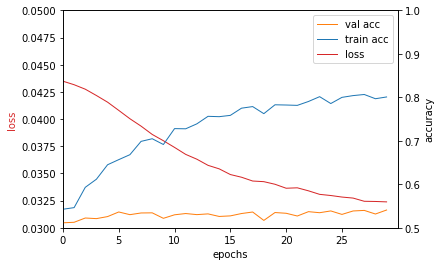

In [30]:
fig, ax1 = plt.subplots()

color = 'tab:red'
loss_line, = ax1.plot(results["epoch"],results["loss"], linewidth=1.0, color=color, label= "loss")
ax1.set(xlim=(0, 30), xticks=np.arange(0, 30, 5),
       ylim=(0.03, 0.05))                                 
ax1.set_ylabel('loss', color=color)                             
ax1.set_xlabel('epochs')
ax2 = ax1.twinx()


train_line, = ax2.plot(results["epoch"],results["train acc"], linewidth=1.0, label='train acc')
val_line, = ax2.plot(results["epoch"],results["val acc"], linewidth=1.0, label='val acc')
ax2.set(xlim=(0, 30), xticks=np.arange(0, 30, 5),
       ylim=(0.5, 1))
ax2.set_ylabel('accuracy')

p = [val_line, train_line, loss_line]
ax2.legend(p, [p_.get_label() for p_ in p])

plt.show()

## GRUs

Gated Recurrent Units (GRUs) are a variant of RNNs that use more complex units for activation. They are created to have more persistent memory thereby making them easier for RNNs to capture long-term dependencies. To learn the theory behind GRUs, we recommend: https://github.com/UBC-NLP/dlnlp2019/blob/master/slides/RNN.pdf 

GRU is defined by ``torch.nn.GRU`` module and its documentation can be fetched [here](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU). Now let us define the GRU module.

In [31]:
"""
define the GRU module
"""
# first input - number of word vector dimensions/embeddings
# second input - number of nodes in hidden layer (50, size of the hidden layer)
# third input - number of recurrent layers (2)
gru_rnn = nn.GRU(input_size=300, hidden_size=50, num_layers=1) # input_size, hidden_size, num_layers

Similar to RNN, GRU module takes two inputs: *the initial hidden state for each element in the batch* (t=0) and the *input features* (``tweet_input_embeddings`` in our case).

Let us feed the sequence embeddings to our GRU model.

In [32]:
"""
forward propagation over the GRU model
"""
output, hn = gru_rnn(embedded)

In [33]:
# output = seq_len, batch, hidden_size (output features from last layer of GRU)
print("output size: ", output.size())

# h_n = num_layers, batch, hidden_size (hidden state for t=seq_len or hidden state at last timestep)
print("last hidden state size: ", hn.size())

output size:  torch.Size([128, 16, 50])
last hidden state size:  torch.Size([1, 16, 50])


## LSTMs

Long short-term memory (LSTMs) are a variant of RNNs that use more complex units for activation. Similar to the spirit of GRU, they are created to have more persistent memory thereby making them easier for RNNs to capture long-term dependencies. To learn the theory behind GRUs, we recommend: https://github.com/UBC-NLP/dlnlp2019/blob/master/slides/RNN.pdf 

LSTM is defined by ``torch.nn.LSTM`` module and its documentation can be fetched [here](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM). Now let us define the LSTM module.

In [34]:
"""
define the LSTM module
"""
# first input - number of features in x (300, size of the word embedding)
# second input - number of number of nodes in a hidden layer (50)
# third input - number of recurrent layers (2)
lstm_rnn = nn.LSTM(input_size=300, hidden_size=50, num_layers=2) # input_size, hidden_size, num_layers

Let us feed the sequence embeddings to our LSTM model. Unlike RNN and GRU, LSTM module has three output: `output, hn, and cn`.

In [35]:
"""
forward propagation over the LSTM model
"""
output, (hn, cn) = lstm_rnn(embedded)

``output`` tensor contains the output features $h_t$ from the last layer of the LSTM

In [36]:
# output = seq_len, batch_size, hidden_size (output features from last layer of LSTM)
print("output size: ", output.size())

output size:  torch.Size([128, 16, 50])


``hn`` is a tensor of shape `[num_layers, batch size, hidden_size]` containing the hidden state for t = seq_len

In [37]:
# h_n = num_layers, batch, hidden_size (hidden state for t=seq_len or hidden state at last timestep)
print("last hidden state size: ", hn.size())

last hidden state size:  torch.Size([2, 16, 50])


``cn`` is a tensor of shape (num_layers, batch, hidden_size) containing the cell state for t = seq_len.

In [38]:
# c_n = num_layers, batch_size, hidden_size (cell state for t=seq_len or cell state at last timestep)
print("last cell state size: ", hn.size())

last cell state size:  torch.Size([2, 16, 50])
